In [26]:
import tensorflow as tf
import tensorflow.keras

# Use matplotlib for visualizing the model
import matplotlib.pyplot as plt
# Import Pandas data processing libraries
import pandas as pd

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print("Tensorflow version:", tf.version.VERSION)

Tensorflow version: 2.15.0


In [5]:
housing_df = pd.read_csv("housing.csv")

In [6]:
housing_df.head() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


__split the datset for ML model__

In [9]:
#split dataset into train, test and validation sets

train, test = train_test_split(housing_df, test_size=0.2)
train, val = train_test_split(train, test_size= 0.2)

print(len(train), "train example")
print(len(val), "Validation example")
print(len(test), "test example")

13209 train example
3303 Validation example
4128 test example


In [10]:
train.to_csv("housing_train.csv", encoding="utf-8", index = False)

In [11]:
val.to_csv('housing_val.csv', encoding='utf-8', index=False)

In [12]:
test.to_csv("housing_test.csv", encoding="utf-8", index = False)

# 1. Create an input pipeline using tf.data

In [13]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('median_house_value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

Initialize training and validation datasets

In [15]:
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

after creating the input pipeline let's check the format of the data it returns. use a small batch siz e to keep the output readable

In [16]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of households:', feature_batch['households'])
    print('A batch of ocean_proximity:', feature_batch['ocean_proximity'])
    print('A batch of targets:', label_batch)

Every feature: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
A batch of households: tf.Tensor(
[ 681. 1070.  467.  307. 1043.  251.  519.  649.   71.  258.  480.  979.
  233.  540.  831.  530.  704.  293.  309.  397.  466.  444.  508.  261.
  365.  595.  229.  421.  356.  334.  414.  342.], shape=(32,), dtype=float64)
A batch of ocean_proximity: tf.Tensor(
[b'NEAR OCEAN' b'<1H OCEAN' b'NEAR BAY' b'<1H OCEAN' b'<1H OCEAN'
 b'<1H OCEAN' b'NEAR BAY' b'<1H OCEAN' b'NEAR OCEAN' b'<1H OCEAN'
 b'<1H OCEAN' b'INLAND' b'NEAR BAY' b'INLAND' b'NEAR OCEAN' b'INLAND'
 b'INLAND' b'INLAND' b'INLAND' b'<1H OCEAN' b'NEAR BAY' b'<1H OCEAN'
 b'<1H OCEAN' b'<1H OCEAN' b'NEAR BAY' b'INLAND' b'<1H OCEAN' b'INLAND'
 b'INLAND' b'NEAR BAY' b'<1H OCEAN' b'INLAND'], shape=(32,), dtype=string)
A batch of targets: tf.Tensor(
[144500. 310000. 358700. 453700. 214000. 380400. 155500. 118300. 137500.
 109400. 278900. 138

__Numeric Columns__

The output of a feature column becomes the input to the model. Numeric Column is used to represent real valued features. When using this column, model will receive the column value from the dataframe unchanged.

In [17]:
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

__Scaler function__

It is very important for numerical variables to get scaled before they are "fed" into the neural network. Here min-max scaling is used. Here a function named 'get_scal' which takes a list of numerical features and returns a 'minmax' function, which will be used in tf.feature_column.numeric_column() as normalizer_fn in parameters. 'Minmax' function itself takes a 'numerical' number from a particular feature and return scaled value of that number. 

In [18]:
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

In [19]:
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [20]:
print('Total number of feature coLumns: ', len(feature_columns))

Total number of feature coLumns:  8


__Build the keras sequential model__

In [22]:
# Model create
# `tf.keras.layers.DenseFeatures()` is a layer that produces a dense Tensor based on given feature_columns.
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)



Epoch 1/32


413/413 [==============================] - 4s 5ms/step - loss: 56507961344.0000 - mse: 56507961344.0000 - val_loss: 56171073536.0000 - val_mse: 56171073536.0000
Epoch 2/32
413/413 [==============================] - 2s 4ms/step - loss: 56507944960.0000 - mse: 56507944960.0000 - val_loss: 56170274816.0000 - val_mse: 56170274816.0000
Epoch 3/32
413/413 [==============================] - 2s 4ms/step - loss: 56506925056.0000 - mse: 56506925056.0000 - val_loss: 56169021440.0000 - val_mse: 56169021440.0000
Epoch 4/32
413/413 [==============================] - 2s 4ms/step - loss: 56505425920.0000 - mse: 56505425920.0000 - val_loss: 56167219200.0000 - val_mse: 56167219200.0000
Epoch 5/32
413/413 [==============================] - 2s 5ms/step - loss: 56503316480.0000 - mse: 56503316480.0000 - val_loss: 56164802560.0000 - val_mse: 56164802560.0000
Epoch 6/32
413/413 [==============================] - 2s 5ms/step - loss: 56500465664.0000 - mse: 56500465664.0000 - val_loss: 561615093

__MSE is the most commonly used regression loss function. MSE is the sum of squared distances between our target variable (e.g. housing median age) and predicted values.__

In [23]:
# Let's show loss as Mean Square Error (MSE)
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

413/413 [==============================] - 1s 3ms/step - loss: 56072761344.0000 - mse: 56072761344.0000
Mean Squared Error 56072761344.0


__Visualize the loss curve__

Visualize the mean squared error loss over the training epochs for both the train (blue) and test (orange) sets.

In [30]:
# model's loss curves for training and validation
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(20, 10))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');  

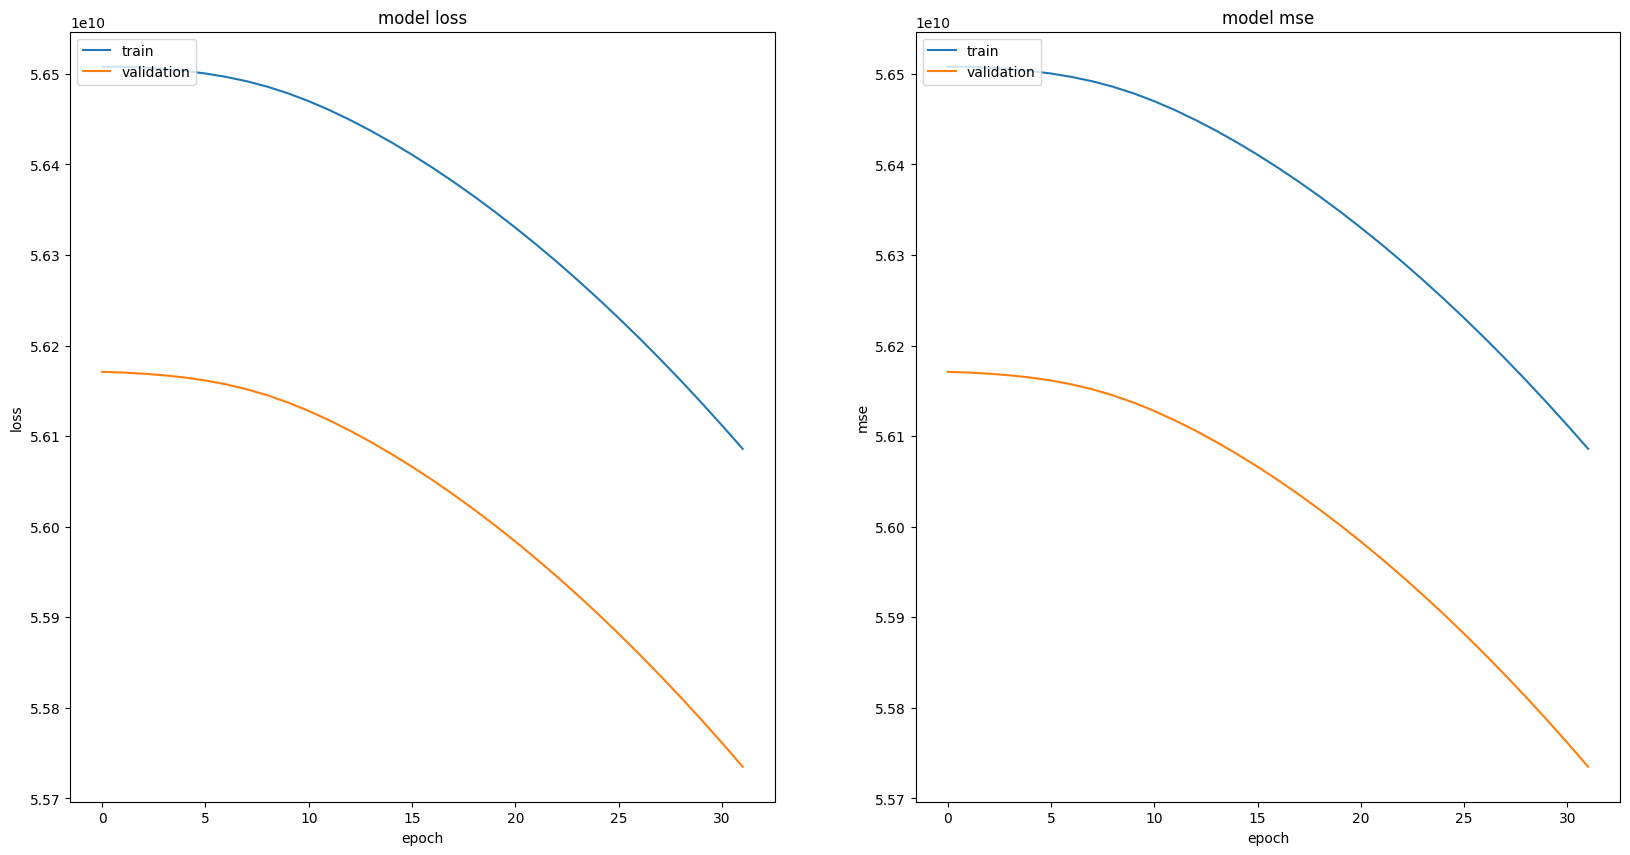

In [31]:
plot_curves(history, ['loss', 'mse'])

__Load test dataset__

In [33]:
test_data = pd.read_csv("housing_test.csv")

In [34]:
test_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.01,39.21,50.0,1592.0,372.0,781.0,307.0,2.2679,69100.0,INLAND
1,-118.33,33.97,44.0,2526.0,579.0,1423.0,573.0,2.5363,158800.0,<1H OCEAN
2,-116.92,32.86,11.0,2204.0,518.0,1472.0,497.0,2.3693,127000.0,<1H OCEAN
3,-118.15,34.13,30.0,2763.0,520.0,1143.0,465.0,4.7298,500001.0,<1H OCEAN
4,-117.67,33.51,17.0,2112.0,480.0,1893.0,433.0,4.0388,120400.0,<1H OCEAN


In [35]:
test_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.000000,4128.000000,4128.000000,4128.000000,4089.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.585954,35.650802,28.491521,2653.095688,541.598190,1426.526163,503.510174,3.819878,204543.645833
std,2.012061,2.141685,12.598627,2210.578200,427.333176,1166.205307,387.856355,1.799872,113683.770849
min,-124.300000,32.560000,2.000000,19.000000,5.000000,9.000000,3.000000,0.499900,14999.000000
25%,-121.830000,33.930000,18.000000,1461.750000,300.000000,790.000000,284.000000,2.553600,118175.000000
50%,-118.530000,34.270000,29.000000,2151.500000,438.000000,1165.000000,411.000000,3.521300,180650.000000
75%,-117.990000,37.710000,37.000000,3149.000000,647.000000,1699.000000,612.000000,4.694400,260325.000000
max,-114.310000,41.950000,52.000000,32627.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


create the input function for the test data and to initialize the test_predict variable.

In [36]:
def test_input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [37]:
test_predict = test_input_fn(dict(test_data))

__Prediction: Linear Regression__

Before we begin to feature engineer our feature columns, we should predict the median house value. By predicting the median house value now, we can then compare it with the median house value after feature engineering.

In [38]:
# Use the model to do prediction with `model.predict()`
predicted_median_house_value = model.predict(test_predict)

17/17 [==============================] - 0s 3ms/step


Next, we run two predictions in separate cells - one where ocean_proximity=INLAND and one where ocean_proximity= NEAR OCEAN.

In [39]:
# Ocean_proximity is INLAND
model.predict({
    'longitude': tf.convert_to_tensor([-121.86]),
    'latitude': tf.convert_to_tensor([39.78]),
    'housing_median_age': tf.convert_to_tensor([12.0]),
    'total_rooms': tf.convert_to_tensor([7653.0]),
    'total_bedrooms': tf.convert_to_tensor([1578.0]),
    'population': tf.convert_to_tensor([3628.0]),
    'households': tf.convert_to_tensor([1494.0]),
    'median_income': tf.convert_to_tensor([3.0905]),
    'ocean_proximity': tf.convert_to_tensor(['INLAND'])
}, steps=1)

1/1 [==============================] - 0s 283ms/step


array([[1053.8676]], dtype=float32)

In [40]:
# Ocean_proximity is NEAR OCEAN
model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]),
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0]),
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
}, steps=1)

1/1 [==============================] - 0s 59ms/step


array([[1053.8676]], dtype=float32)

The arrays returns a predicted value.  What do these numbers mean?  Let's compare this value to the test set.  

Go to the test.csv you read in a few cells up.  Locate the first line and find the median_house_value - which should be 249,000 dollars near the ocean. What value did your model predicted for the median_house_value? Was it a solid model performance? Let's see if we can improve this a bit with feature engineering! 

## Engineer features to create categorical and numerical features

Now we create a cell that indicates which features will be used in the model.
Note: Be sure to bucketize 'housing_median_age' and ensure that 'ocean_proximity' is one-hot encoded. And, don't forget your numeric values!

In [41]:
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']

bucketized_cols = ['housing_median_age']

# indicator columns,Categorical features
categorical_cols = ['ocean_proximity']

Next, we scale the numerical, bucktized, and categorical feature columns that we assigned to the variables in the preceding cell.

In [42]:
# Scalar def get_scal(feature):
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

In [43]:
# All numerical features - scaling
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))

In [44]:
feature_columns

[NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

## Categorical Feature

In this dataset, 'ocean_proximity' is represented as a string. We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector.

In [45]:
for feature_name in categorical_cols:
    vocabulary = housing_df[feature_name].unique()
    categorical_c = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    one_hot = fc.indicator_column(categorical_c)
    feature_columns.append(one_hot)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


## Bucketized Feature

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider our raw data that represents a homes' age. Instead of representing the house age as a numeric column, we could split the home age into several buckets using a bucketized column. Notice the one-hot values below describe which age range each row matches.

In [46]:
## 

age = fc.numeric_column("housing_median_age")

# Bucketized cols
age_buckets = fc.bucketized_column(age, boundaries=[10, 20, 30, 40, 50, 60, 80, 100])
feature_columns.append(age_buckets)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


## Feature Cross

Combining features into a single feature, better known as feature crosses, enables a model to learn separate weights for each combination of features.

Nex e create a feature cross of 'housing_median_age' and 'ocean_proximity'.

In [47]:
vocabulary = housing_df['ocean_proximity'].unique()
ocean_proximity = fc.categorical_column_with_vocabulary_list('ocean_proximity',
                                                             vocabulary)

crossed_feature = fc.crossed_column([age_buckets, ocean_proximity],
                                    hash_bucket_size=1000)
crossed_feature = fc.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


validate the total number of feature columns. Compare this number to the number of numeric features you input earlier.

In [48]:
print('Total number of feature columns: ', len(feature_columns))

Total number of feature columns:  11


In [49]:
#compile and fit the Keras Sequential model

feature_layer = tf.keras.layers.DenseFeatures(feature_columns,
                                              dtype='float64')

# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
413/413 [==============================] - 4s 6ms/step - loss: 56508588032.0000 - mse: 56508588032.0000 - val_loss: 56171233280.0000 - val_mse: 56171233280.0000
Epoch 2/32
413/413 [==============================] - 3s 6ms/step - loss: 56508309504.0000 - mse: 56508309504.0000 - val_loss: 56170872832.0000 - val_mse: 56170872832.0000
Epoch 3/32
413/413 [==============================] - 2s 5ms/step - loss: 56507785216.0000 - mse: 56507785216.0000 - val_loss: 56170090496.0000 - val_mse: 56170090496.0000
Epoch 4/32
413/413 [==============================] - 2s 5ms/step - loss: 56506609664.0000 - mse: 56506609664.0000 - val_loss: 56168488960.0000 - val_mse: 56168488960.0000
Epoch 5/32
413/413 [==============================] - 2s 6ms/step - loss: 56504471552.0000 - mse: 56504471552.0000 - val_loss: 56165801984.0000 - val_mse: 56165801984.0000
Epoch 6/32
413/413 [==============================] - 3s 6ms/step - loss: 56501317632.0000 - mse: 56501317632.0000 - val_loss: 56162099200.0

In [50]:
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

413/413 [==============================] - 1s 3ms/step - loss: 56217640960.0000 - mse: 56217640960.0000
Mean Squared Error 56217640960.0


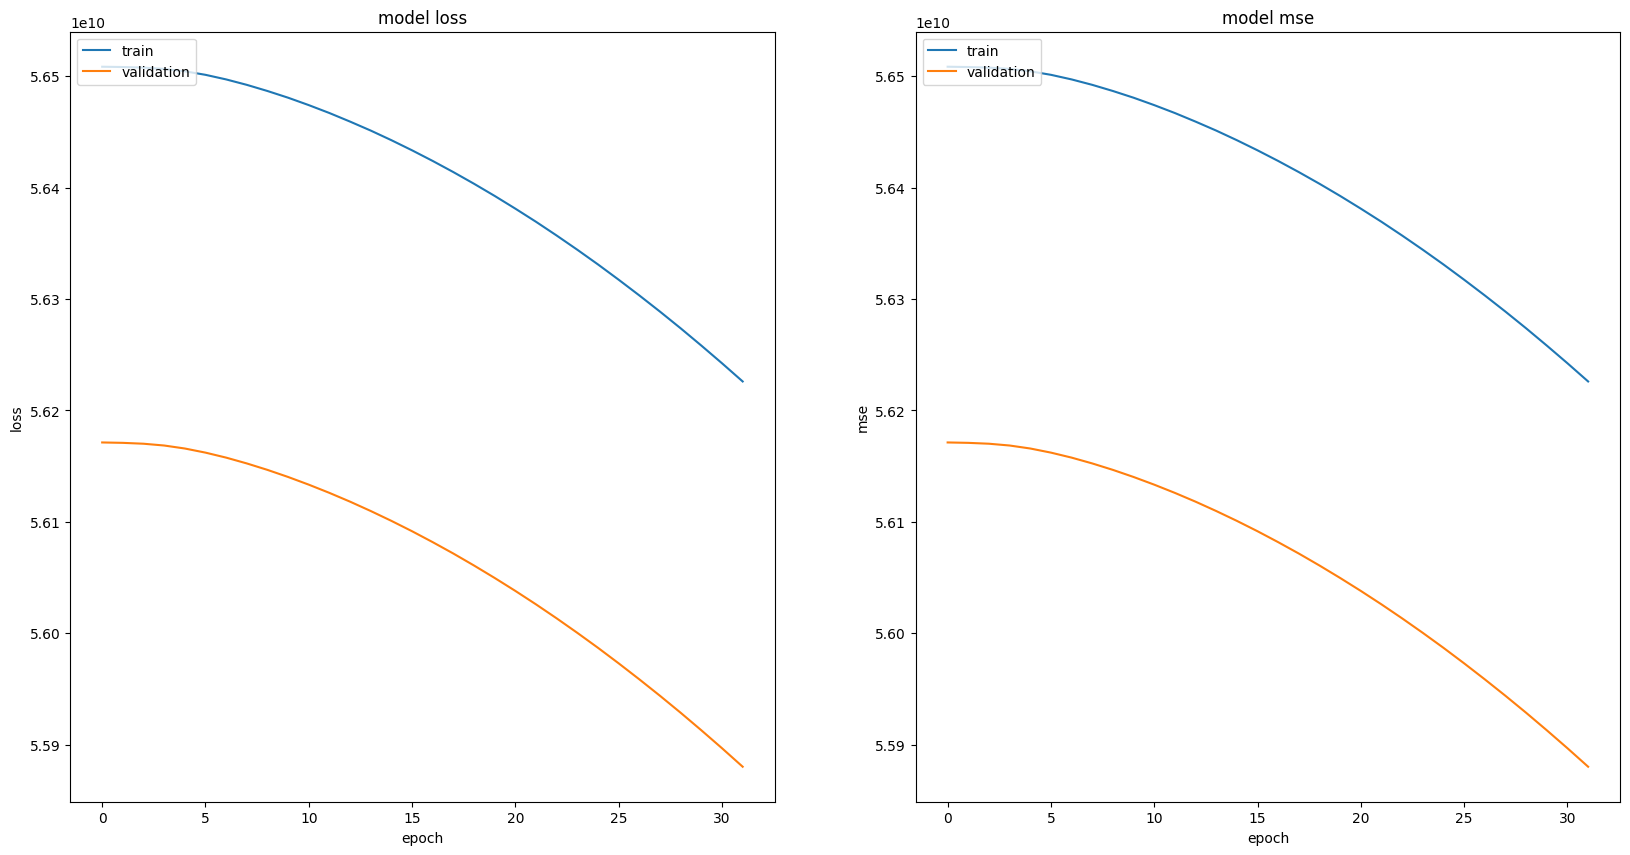

In [51]:
plot_curves(history, ['loss', 'mse'])

In [52]:
# Median_house_value is $249,000, prediction is $234,000 NEAR OCEAN
model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]),
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0]),
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
}, steps=1)

1/1 [==============================] - 0s 385ms/step


array([[703.0498]], dtype=float32)